test the basic functions needed to create the cube rendering

In [49]:
import pyvista as pv
import numpy as np
import netCDF4 as nc
import vtk
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from skimage import io
import cv2
import logging
#import gemgis as gg

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Load data

In [50]:
path_input_mesh = '../../UFZ_RemoteSensing/NOAA-LAI-Europe-mon-2001-2012(1).nc'
path_input_mesh = '../../UFZ_RemoteSensing/HOLAPS-H-JJA_anomaly-d-2001-2005.nc'
path_input_color = '../../UFZ_RemoteSensing/HOLAPS-H-JJA_anomaly-d-2001-2005.nc'
path_input_BG = '../backgound_map_tests/shadedrelief.png'

### dataset for mesh

In [51]:
def load_nc(path_input, min_zero=False):
    ds = nc.Dataset(path_input)
    arr_name = [n for n in ds.variables.keys() if ds[n].ndim==3][0]
    arr = ds[arr_name][0]
    fill_value = -999
    arr = arr.filled(fill_value=np.nan)
    arr = arr - np.nanmin(arr) if min_zero else arr
    
    lat_arr = ds['latitude'][:]
    long_arr = ds['longitude'][:]
    
    logging.info(f'Read netCDF {arr_name} data. Shape={ds[arr_name].shape}')
    
    return arr, lat_arr, long_arr

In [52]:
# Read datasets:

arr_mesh, lat_arr_mesh, long_arr_mesh = load_nc(path_input_mesh, min_zero=True)

arr_color, lat_arr_color, long_arr_color = load_nc(path_input_color)

bg = np.flip(io.imread(path_input_BG), axis=0)

INFO:root:Read netCDF surface_upward_sensible_heat_flux data. Shape=(460, 601, 1233)
INFO:root:Read netCDF surface_upward_sensible_heat_flux data. Shape=(460, 601, 1233)


### match data size

In [55]:
def find_idx_nearest(arr, val):
    return (np.abs(arr - val)).argmin()

def get_world_part(arr, lat_arr_src, long_arr_src, 
                   lat_arr_dst=None, long_arr_dst=None):
    
    if lat_arr_dst is None:
        lat_arr_dst = np.linspace(-90, 90, arr.shape[0])
        long_arr_dst = np.linspace(-180, 180, arr.shape[1])

    min_lat_idx = find_idx_nearest(lat_arr_dst, np.min(lat_arr_src))
    max_lat_idx = find_idx_nearest(lat_arr_dst, np.max(lat_arr_src))

    min_long_idx = find_idx_nearest(long_arr_dst, np.min(long_arr_src))
    max_long_idx = find_idx_nearest(long_arr_dst, np.max(long_arr_src))

    arr = arr[min_lat_idx:max_lat_idx, min_long_idx:max_long_idx]
    lat_arr_dst = lat_arr_dst[min_lat_idx:max_lat_idx]
    long_arr_dest = long_arr_dst[min_long_idx:max_long_idx]
    
    return arr, lat_arr_dst, long_arr_dest

In [56]:
arr_mesh, lat_arr_mesh, long_arr_mesh = get_world_part(arr_mesh, 
                                                       lat_arr_color, 
                                                       long_arr_color,
                                                       lat_arr_mesh, 
                                                       long_arr_mesh)
bg = get_world_part(bg, lat_arr_mesh, long_arr_mesh)[0]
arr_color = get_world_part(arr_color, 
                           lat_arr_mesh, long_arr_mesh,
                           lat_arr_color, long_arr_color)[0]

In [57]:
arr_mesh = cv2.resize(arr_mesh, bg.shape[:2][::-1], 
                      interpolation=cv2.INTER_NEAREST).T
arr_color = cv2.resize(arr_color, bg.shape[:2][::-1], 
                      interpolation=cv2.INTER_NEAREST).T

In [58]:
path_bg = 'tmp.png'
io.imsave(path_bg, np.flip(bg,axis=0))
bg = pv.read(path_bg)
#print(bg.bounds)
logging.info(bg)

INFO:root:UniformGrid (0x7fb30a3a94c0)
  N Cells:	845397
  N Points:	847360
  X Bounds:	0.000e+00, 1.323e+03
  Y Bounds:	0.000e+00, 6.390e+02
  Z Bounds:	0.000e+00, 0.000e+00
  Dimensions:	1324, 640, 1
  Spacing:	1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:	1



## Color data 

In [62]:
# def normalize_arr_vals(arr, new_range=(0,256)):
#     min_val = np.nanmin(arr_color)
#     max_val = np.nanmax(arr_color)
    
#     arr_normed = np.nan_to_num((arr - new_range[0])/np.ptp(new_range)*254 + 1, 0
#                                 ).astype(np.uint8)
#     return arr_normed


# def cmap_to_4channel(cmap):
#     colmap = cm.get_cmap(cmap)
#     if isinstance(colmap, colors.LinearSegmentedColormap):
#         colmap = (colmap(np.arange(0,colmap.N))*np.asarray([255,255,255,255]).astype(np.uint8))
    
#     # greater opacity for mid values:
#     for i in range(1,128):
#         colmap[i,3] = 255-(i-1)*2
#         colmap[256-i,3] = 255-(i-1)*2

#     colmap[128,3] = 1
#     colmap[0, 3] = 0
    
#     return colmap


# def arr_color_to_4channel(arr, cmap='jet'):
#     cmap_4channel = cmap_to_4channel(cmap)
    
#     arr = normalize_arr_vals(arr)
#     arr_color_4channel = np.take(cmap_4channel, arr, axis=0).reshape((arr.size,4))
#     #np.array([255,255,255,255])
    
#     return arr_color_4channel

In [63]:
#arr_color_4channel = arr_color_to_4channel(arr_color)

## Make dataset mesh

In [64]:
def make_floor_vertices(arr):

    xs,ys = np.meshgrid(range(arr.shape[0]),range(arr.shape[1]))
    
    vertices_base = np.vstack((xs.T.flatten(), 
                        ys.T.flatten(),
                        np.zeros(xs.size))).T
    
    xs,ys = np.meshgrid(range(arr.shape[0]),[arr.shape[1]])
    vertices_edge_y = np.vstack((xs.T.flatten(), 
                        ys.T.flatten(),
                        np.zeros(xs.size))).T
    
    xs,ys = np.meshgrid(arr.shape[0],range(arr.shape[1]))
    vertices_edge_x = np.vstack((xs.T.flatten(), 
                        ys.T.flatten(),
                        np.zeros(xs.size))).T
        
    return vertices_base, vertices_edge_y, vertices_edge_x

In [65]:
def concat_all_vertices(arr, vertices_base, vertices_edge_y, vertices_edge_x):
    
    vertices_ceil = vertices_base.copy()
    vertices_ceil[:,2] = arr.flatten()
    
    vertices = np.concatenate((vertices_base,
                               vertices_edge_y,
                               vertices_edge_x,
                               vertices_ceil,
                               vertices_ceil+[0,1,0],
                               vertices_ceil+[1,1,0],
                               vertices_ceil+[1,0,0],
                          ))
    
    return vertices

In [22]:
def make_vertices(arr):
    vertices_base, vertices_edge_y, vertices_edge_x = make_floor_vertices(arr)
    vertices = concat_all_vertices(arr, vertices_base, vertices_edge_y, vertices_edge_x)
    
    n_floor_v = vertices_base.shape[0]+vertices_edge_y.shape[0]+vertices_edge_x.shape[0]
    return vertices, n_floor_v

In [23]:
def make_floor_faces(arr):
    faces = []
    it = np.nditer(arr, flags=['c_index','multi_index'])

    for x in it:
        if not np.isnan(x):
            
            neigh_right_idx = it.index+1 if it.multi_index[1]!=arr.shape[1]-1 \
                                else arr.size + it.multi_index[0] 
            neigh_down_idx = it.index+arr.shape[1] if it.multi_index[0]!=arr.shape[0]-1 \
                                else arr.size + arr.shape[0] + it.multi_index[1]
            
            neigh_diag_idx = it.index+arr.shape[1]+1
            if neigh_down_idx>arr.size:
                neigh_diag_idx = neigh_down_idx+1
            elif neigh_right_idx>arr.size-1:
                neigh_diag_idx = neigh_right_idx+1

            faces.append(np.array([4,
                                   it.index,
                                   neigh_right_idx,
                                   neigh_diag_idx,
                                   neigh_down_idx,
                                  ]))
            
    return faces

In [24]:
def make_ceil_faces(arr, n_v_floor):

    faces = []
    it = np.nditer(arr, flags=['c_index','multi_index'])

    for x in it:
        if not np.isnan(x):
            faces.append(np.array([4,
                                   n_v_floor+it.index,
                                   n_v_floor+arr.size+it.index,
                                   n_v_floor+arr.size*2+it.index,
                                   n_v_floor+arr.size*3+it.index,
                                  ]))
    
    return faces

In [25]:
def make_side_faces(faces):
    side_faces = []

    for i in range(len(faces)//2):
        side_faces.append(np.array([4,
                               faces[i][1],
                               faces[i][2],
                               faces[len(faces)//2+i][2],
                               faces[len(faces)//2+i][1],
                              ]))
        side_faces.append(np.array([4,
                               faces[i][1],
                               faces[i][4],
                               faces[len(faces)//2+i][4],
                               faces[len(faces)//2+i][1],
                              ]))
        side_faces.append(np.array([4,
                               faces[i][2],
                               faces[i][3],
                               faces[len(faces)//2+i][3],
                               faces[len(faces)//2+i][2],
                              ]))
        side_faces.append(np.array([4,
                               faces[i][3],
                               faces[i][4],
                               faces[len(faces)//2+i][4],
                               faces[len(faces)//2+i][3],
                              ]))
        
    return side_faces

In [26]:
def make_faces(arr, n_floor_v):
    faces = make_floor_faces(arr)
    faces.extend(make_ceil_faces(arr, n_floor_v))
    faces.extend(make_side_faces(faces))
    
    return faces

In [27]:
# def make_face_color(arr_color_cmap, arr_mesh):
#     arr_color_cmap = np.delete(arr_color_cmap, np.isnan(arr_mesh.flatten()), axis=0)
#     colormap = np.concatenate((np.tile(np.array([1.,1.,1.,0.5]), (arr_color_cmap.shape[0],1)),
#                                np.tile(np.array([1.,1.,1.,0.5]), (arr_color_cmap.shape[0],1)),
#                                #arr_color_cmap,
#                                np.tile(np.array([1.,1.,1.,0.5]), (arr_color_cmap.shape[0]*4,1))))
#     return colormap

In [109]:
def make_face_color(arr_color_flat, arr_mesh, clim):
    arr_color_flat = np.delete(arr_color_flat, np.isnan(arr_mesh.flatten(order='F')))
    
    faces_color = np.concatenate((np.tile(arr_color_flat, 2),
                               np.tile(arr_color_flat, (4,1)).flatten(order='F')))
    
    arr_color_opacity = (np.abs(arr_color_flat-np.mean([clim[0],clim[1]])) / (np.ptp(clim)/2))*2
    
    faces_opacity = np.concatenate((np.tile(arr_color_opacity, 2),
                               np.tile(arr_color_opacity, (4,1)).flatten(order='F')))    
    
    faces_opacity[faces_opacity>1] = 1.0
    
    return faces_color, faces_opacity

In [110]:
clim=(-100,100)

vertices, n_floor_v = make_vertices(arr_mesh)
faces = make_faces(arr_mesh, n_floor_v)

surf = pv.PolyData(vertices, faces)

faces_color, faces_opacity = make_face_color(arr_color.flatten(order='F'), arr_mesh, clim)
surf["colors"] = faces_color
surf["opacity"] = faces_opacity

In [111]:
np.unique(surf["colors"])

pyvista_ndarray([-111.63459 , -107.13638 ,  -99.7192  , ...,  114.66737 ,
                  119.272026,         nan], dtype=float32)

In [112]:
np.unique(np.around(surf["opacity"], decimals=2))

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ,  nan], dtype=float32)

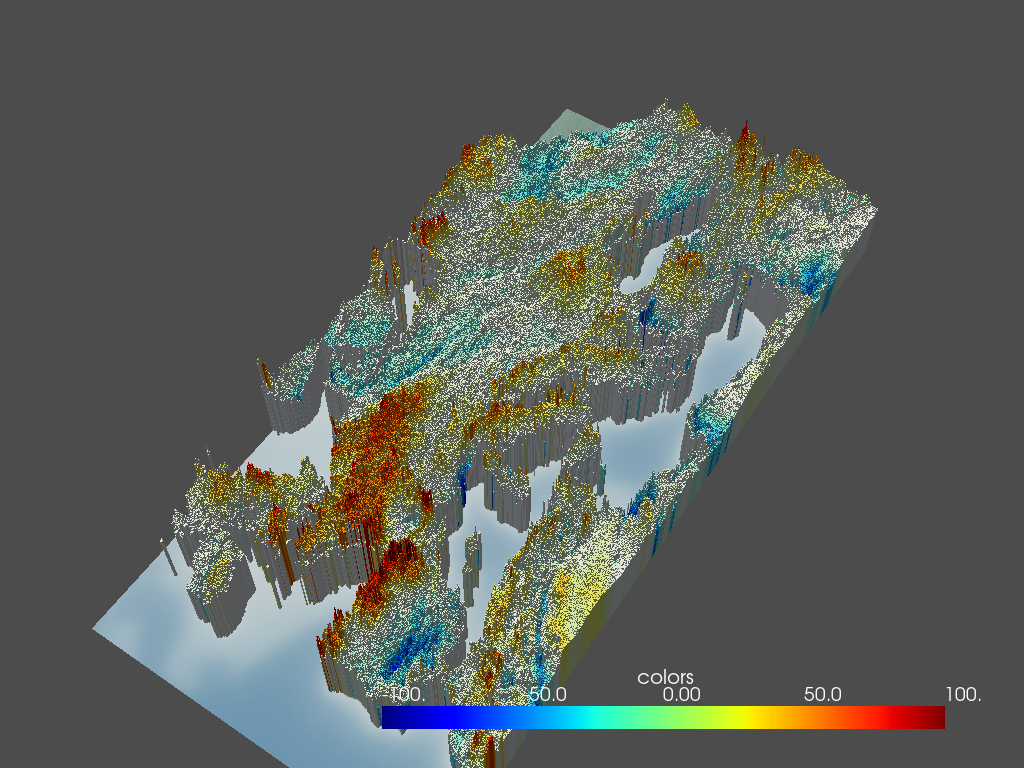

In [113]:
p = pv.Plotter()
p.add_mesh(bg, rgb=True, scalars='PNGImage')#,  show_edges=True)
p.add_mesh(surf, color='white')
p.add_mesh(surf, scalars="colors", cmap='jet', clim=clim, opacity="opacity")
#show_edges=True, use_transparency=True, rgb=True
#p.camera_position = 'xz'
#p.camera.zoom(2)
p.camera.position = (-400, -400, 2000)
p.show()